In [165]:
# Check if running on Google Colab
try:
    import google.colab
    IN_COLAB = True
    print("Running on Google Colab")
except:
    IN_COLAB = False
    print("Running locally")

# Install required packages (only needed on Colab)
if IN_COLAB:
    print("\nInstalling required packages...")
    !pip install -q torch torchvision tqdm pyyaml scikit-learn pandas matplotlib seaborn
    print("Packages installed")

# Mount Google Drive if on Colab
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

    # Set project path to match your data exploration notebook
    import os
    PROJECT_PATH = "/content/drive/MyDrive/WOA7015 Advanced Machine Learning"

    # Check if path exists
    if not os.path.exists(PROJECT_PATH):
        print(f"Path not found: {PROJECT_PATH}")
        print("Please make sure your data is uploaded to:")
        print("MyDrive/WOA7015 Advanced Machine Learning/")
        print("\nExpected structure:")
        print("  data/")
        print("    ├── trainrenamed.csv")
        print("    ├── testrenamed.csv")
        print("    ├── answers.txt")
        print("    ├── config_lightweight.yaml (optional)")
        print("    ├── src/ (project source code)")
        print("    └── train/ (images folder)")
    else:
        print(f"  Project path found: {PROJECT_PATH}")
        os.chdir(PROJECT_PATH)
else:
    # Local path
    PROJECT_PATH = None
    print("Running locally - no setup needed")

Running on Google Colab

Installing required packages...
Packages installed
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
  Project path found: /content/drive/MyDrive/WOA7015 Advanced Machine Learning


## 0. Google Colab Setup (Run this first if using Colab)

# Text-Only VQA Baseline Training

**Goal**: Train a language model to answer medical questions based on text only (without images)

This notebook walks through:
1. Loading and exploring the data
2. Building vocabulary from questions
3. Creating an LSTM model
4. Training the model
5. Evaluating performance
6. Analyzing results

**Note**: Can run on Google Colab (free tier) - no GPU needed for text-only baseline!

## 1. Setup and Imports

In [166]:
import sys
import os
from pathlib import Path

# Setup paths based on environment
if IN_COLAB:
    # Already in project directory from Colab setup
    project_root = Path(PROJECT_PATH)
else:
    # Local path - running from notebooks directory
    project_root = Path().absolute().parent

sys.path.insert(0, str(project_root))

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import yaml
from tqdm.notebook import tqdm

# Verify src directory existence
src_path = project_root / "src"
if not src_path.exists():
    print(f"Error: The 'src' directory was not found at {src_path}")
    print("Please ensure your project structure includes a 'src' folder within your PROJECT_PATH.")
    # This allows the ModuleNotFoundError to still be raised, but with prior context.

# Import our modules
from src.data.dataset import TextOnlyVQADataset, create_text_dataloaders
from src.models.text_model import LSTMTextModel, create_text_model
from src.training.trainer import TextVQATrainer
from src.evaluation.metrics import VQAMetrics, calculate_accuracy

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Imports successful")
print(f"Project root: {project_root}")
print(f"PyTorch version: {torch.__version__}")
print(f"Device available: {'CUDA' if torch.cuda.is_available() else 'CPU'}")

Imports successful
Project root: /content/drive/MyDrive/WOA7015 Advanced Machine Learning
PyTorch version: 2.9.0+cpu
Device available: CPU


In [167]:
init_file_path = project_root / "src" / "models" / "__init__.py"
if init_file_path.exists():
    print(f"Contents of {init_file_path}:")
    with open(init_file_path, 'r') as f:
        print(f.read())
else:
    print(f"Error: __init__.py not found at {init_file_path}")

Contents of /content/drive/MyDrive/WOA7015 Advanced Machine Learning/src/models/__init__.py:
"""Model architectures"""
# from .baseline_cnn import BaselineCNNModel # Commented for text-only VQA
# from .vlm_model import VLMModel # Commented for text-only VQA



In [168]:
import os

print(f"Listing contents of {PROJECT_PATH}:")
for item in os.listdir(PROJECT_PATH):
    print(f"- {item}")

src_check_path = os.path.join(PROJECT_PATH, 'src')
if os.path.isdir(src_check_path):
    print(f"\n  'src' directory found at: {src_check_path}")
else:
    print(f"\n  'src' directory NOT found at: {src_check_path}")
    print("Please create a 'src' folder there and move your dataset.py, model.py, trainer.py, and metrics.py files into it.")

Listing contents of /content/drive/MyDrive/WOA7015 Advanced Machine Learning:
- data
- results
- val_split.csv
- train_split.csv
- 02_text_baseline_training.ipynb
- src
- checkpoints

  'src' directory found at: /content/drive/MyDrive/WOA7015 Advanced Machine Learning/src


## 2. Load Configuration

In [169]:
# Load lightweight configuration (or create default if not exists)
config_path = project_root / "config_lightweight.yaml"

if config_path.exists():
    with open(config_path, 'r') as f:
        config = yaml.safe_load(f)
    print("Loaded config_lightweight.yaml")
else:
    # Create default lightweight config for Colab
    print("config_lightweight.yaml not found, using default settings")
    config = {
        'data': {'train_csv': 'data/trainrenamed.csv', 'test_csv': 'data/testrenamed.csv',
                 'answers_file': 'data/answers.txt', 'val_split': 0.15},
        'text': {'max_length': 32, 'embedding_dim': 128},
        'model': {'baseline': {'hidden_dim': 256, 'num_layers': 1, 'dropout': 0.2}},
        'training': {'batch_size': 8, 'num_epochs': 10, 'learning_rate': 0.001,
                    'weight_decay': 0.0001, 'scheduler': 'step', 'gradient_clip': 1.0,
                    'early_stopping_patience': 5},
        'paths': {'checkpoints': 'checkpoints'},
        'seed': 42
    }

print("\nConfiguration:")
print(f"  Batch size: {config['training']['batch_size']}")
print(f"  Epochs: {config['training']['num_epochs']}")
print(f"  Learning rate: {config['training']['learning_rate']}")
print(f"  Hidden dim: {config['model']['baseline']['hidden_dim']}")
print(f"  Embedding dim: {config['text']['embedding_dim']}")
print(f"  Max sequence length: {config['text']['max_length']}")

config_lightweight.yaml not found, using default settings

Configuration:
  Batch size: 8
  Epochs: 10
  Learning rate: 0.001
  Hidden dim: 256
  Embedding dim: 128
  Max sequence length: 32


## 3. Explore the Data

In [170]:
# Load training data
data_path = project_root
print(f"  loade data from {data_path}")

train_df = pd.read_csv(project_root / config['data']['train_csv'])
test_df = pd.read_csv(project_root / config['data']['test_csv'])
print(f" Data loaded from {project_root}")
print(f"Training samples: {len(train_df):,}")
print(f"Test samples: {len(test_df):,}")
print(f"\nColumns: {list(train_df.columns)}")
print(f"\nFirst few samples:")
train_df.head()

  loade data from /content/drive/MyDrive/WOA7015 Advanced Machine Learning
 Data loaded from /content/drive/MyDrive/WOA7015 Advanced Machine Learning
Training samples: 19,755
Test samples: 6,761

Columns: ['image', 'question', 'answer']

First few samples:


,image,question,answer
0,image1,What is the appearance of the chromatin textur...,a salt-and-pepper pattern
1,image1,"Does the chromatin texture, with fine and coa...",yes
2,image1,Do neutrophils assume a salt-and-pepper pattern?,no
3,image1,Does granulomatous host response show the blan...,no
4,image1,Does high magnification show the bland cytolog...,yes


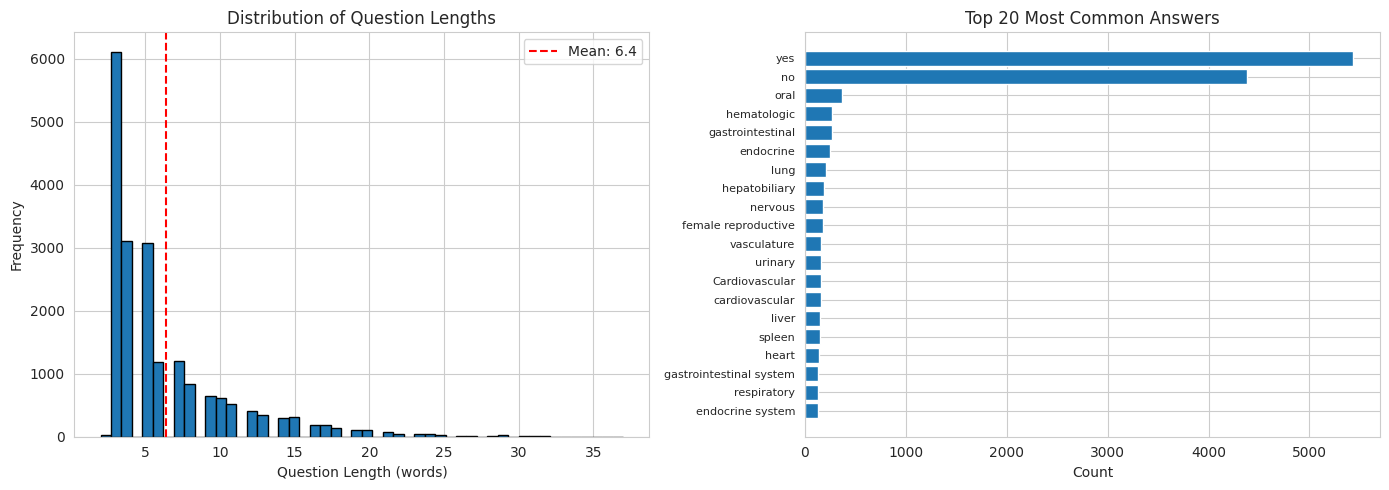

Question length statistics:
  Mean: 6.35 words
  Median: 5 words
  Max: 37 words

Unique answers: 3,273


In [171]:
# Analyze questions
train_df['question_length'] = train_df['question'].str.split().str.len()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Question length distribution
axes[0].hist(train_df['question_length'], bins=50, edgecolor='black')
axes[0].set_xlabel('Question Length (words)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Question Lengths')
axes[0].axvline(train_df['question_length'].mean(), color='red', linestyle='--', label=f'Mean: {train_df["question_length"].mean():.1f}')
axes[0].legend()

# Answer distribution (top 20)
top_answers = train_df['answer'].value_counts().head(20)
axes[1].barh(range(len(top_answers)), top_answers.values)
axes[1].set_yticks(range(len(top_answers)))
axes[1].set_yticklabels(top_answers.index, fontsize=8)
axes[1].set_xlabel('Count')
axes[1].set_title('Top 20 Most Common Answers')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

print(f"Question length statistics:")
print(f"  Mean: {train_df['question_length'].mean():.2f} words")
print(f"  Median: {train_df['question_length'].median():.0f} words")
print(f"  Max: {train_df['question_length'].max():.0f} words")
print(f"\nUnique answers: {train_df['answer'].nunique():,}")

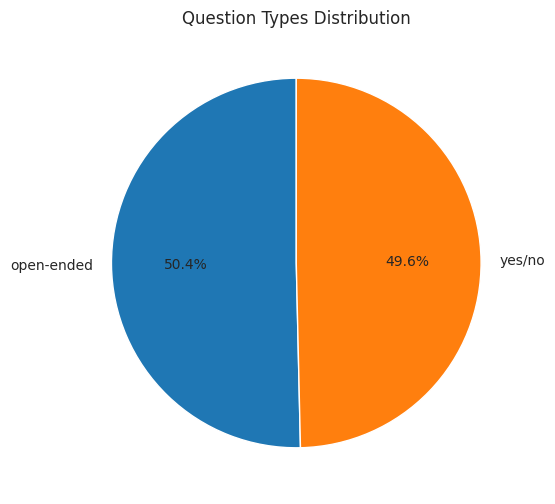

Question type breakdown:
  open-ended: 9,949 (50.4%)
  yes/no: 9,806 (49.6%)


In [172]:
# Analyze question types
def classify_question_type(answer):
    answer_lower = str(answer).lower().strip()
    if answer_lower in ['yes', 'no']:
        return 'yes/no'
    else:
        return 'open-ended'

train_df['question_type'] = train_df['answer'].apply(classify_question_type)

question_type_counts = train_df['question_type'].value_counts()

plt.figure(figsize=(8, 6))
plt.pie(question_type_counts.values, labels=question_type_counts.index,
        autopct='%1.1f%%', startangle=90)
plt.title('Question Types Distribution')
plt.show()

print("Question type breakdown:")
for qtype, count in question_type_counts.items():
    print(f"  {qtype}: {count:,} ({count/len(train_df)*100:.1f}%)")

## 4. Create Dataloaders

In [173]:
# Create dataloaders
print("Creating dataloaders...")

train_loader, val_loader, test_loader, vocab_size, num_classes, vocab = create_text_dataloaders(
    train_csv=str(data_path / config['data']['train_csv']),
    test_csv=str(data_path / config['data']['test_csv']),
    answers_file=str(data_path / config['data']['answers_file']),
    batch_size=config['training']['batch_size'],
    val_split=config['data']['val_split'],
    num_workers=0,
    max_length=config['text']['max_length']
)

print(f"\n  Dataloaders created:")
print(f"  Vocabulary size: {vocab_size:,}")
print(f"  Number of answer classes: {num_classes:,}")
print(f"  Train batches: {len(train_loader):,}")
print(f"  Val batches: {len(val_loader):,}")
print(f"  Test batches: {len(test_loader):,}")

Creating dataloaders...
Loaded 19755 samples from /content/drive/MyDrive/WOA7015 Advanced Machine Learning/data/trainrenamed.csv
Answer vocabulary size: 4592
Built vocabulary with 3965 tokens
Train size: 16791, Val size: 2964
Loaded 6761 samples from /content/drive/MyDrive/WOA7015 Advanced Machine Learning/data/testrenamed.csv
Answer vocabulary size: 4592

  Dataloaders created:
  Vocabulary size: 3,965
  Number of answer classes: 4,592
  Train batches: 2,099
  Val batches: 371
  Test batches: 846


In [174]:
# Inspect a sample batch
sample_batch = next(iter(train_loader))

print("Sample batch:")
print(f"  Question tensor shape: {sample_batch['question'].shape}")
print(f"  Answer tensor shape: {sample_batch['answer'].shape}")
print(f"\nFirst question (encoded): {sample_batch['question'][0][:20].tolist()}...")
print(f"First question (text): {sample_batch['question_text'][0]}")
print(f"First answer: {sample_batch['answer_text'][0]}")

Sample batch:
  Question tensor shape: torch.Size([8, 32])
  Answer tensor shape: torch.Size([8])

First question (encoded): [2, 4, 1629, 488, 5, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]...
First question (text): Is hypertrophic gastritis present?
First answer: yes


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [175]:
# Show vocabulary statistics
print("Vocabulary sample (first 20 tokens):")
sorted_vocab = sorted(vocab.items(), key=lambda x: x[1])[:20]
for token, idx in sorted_vocab:
    print(f"  {idx:3d}: '{token}'")

Vocabulary sample (first 20 tokens):
    0: '<PAD>'
    1: '<UNK>'
    2: '<SOS>'
    3: '<EOS>'
    4: 'is'
    5: 'present'
    6: 'what'
    7: 'does'
    8: 'show'
    9: 'this'
   10: 'image'
   11: 'the'
   12: 'of'
   13: 'and'
   14: 'in'
   15: 'where'
   16: 'with'
   17: 'are'
   18: 'to'
   19: 'cells'


## 5. Create the Model

In [176]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create model
model = create_text_model(
    model_type='lstm',
    vocab_size=vocab_size,
    num_classes=num_classes,
    embedding_dim=config['text']['embedding_dim'],
    hidden_dim=config['model']['baseline']['hidden_dim'],
    num_layers=config['model']['baseline']['num_layers'],
    dropout=config['model']['baseline']['dropout'],
    bidirectional=True
)

model = model.to(device)

# Model summary
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n  Model created:")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Model size: ~{total_params * 4 / (1024**2):.2f} MB")
print(f"\nModel architecture:")
print(model)

Using device: cpu

  Model created:
  Total parameters: 2,609,520
  Trainable parameters: 2,609,520
  Model size: ~9.95 MB

Model architecture:
LSTMTextModel(
  (embedding): Embedding(3965, 128, padding_idx=0)
  (lstm): LSTM(128, 256, batch_first=True, bidirectional=True)
  (classifier): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=256, out_features=4592, bias=True)
  )
)


In [177]:
# Test forward pass
model.eval()
with torch.no_grad():
    test_questions = sample_batch['question'][:4].to(device)
    test_outputs = model(test_questions)
    test_probs = torch.softmax(test_outputs, dim=1)
    test_preds = test_outputs.argmax(dim=1)

print("Test forward pass:")
print(f"  Input shape: {test_questions.shape}")
print(f"  Output shape: {test_outputs.shape}")
print(f"  Predictions: {test_preds.cpu().numpy()}")
print(f"  Max probabilities: {test_probs.max(dim=1)[0].cpu().numpy()}")
print("\n Model is working correctly!")

Test forward pass:
  Input shape: torch.Size([4, 32])
  Output shape: torch.Size([4, 4592])
  Predictions: [2231 2231 2231 4495]
  Max probabilities: [0.00021916 0.00021929 0.00021925 0.00021911]

 Model is working correctly!


## 6. Training Setup

In [178]:

# Set random seed for reproducibility
torch.manual_seed(config['seed'])
if torch.cuda.is_available():
    torch.cuda.manual_seed(config['seed'])

# Create trainer
trainer = TextVQATrainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    config=config,
    device=device,
    checkpoint_dir=str(project_root / config['paths']['checkpoints']),
    experiment_name="text_baseline_lstm_notebook"
)

print(" Trainer initialized")
print(f" Checkpoints will be saved to: {trainer.checkpoint_dir}")

Initialized trainer for text_baseline_lstm_notebook
Model parameters: 2,609,520
 Trainer initialized
 Checkpoints will be saved to: /content/drive/MyDrive/WOA7015 Advanced Machine Learning/checkpoints/text_baseline_lstm_notebook


## 7. Train the Model

**Note**: This will take some time depending on your laptop specs:
- **Quick test (2 epochs)**: ~5-10 minutes
- **Full training (10 epochs)**: ~30-60 minutes

In [179]:
# Optional: Reduce epochs for quick testing
# config['training']['num_epochs'] = 2  # Uncomment for quick test

# Start training
print("Starting training...\n")
trainer.train()

print(f"\n  Training completed!")
print(f"Best validation accuracy: {trainer.best_val_acc:.4f}")

Starting training...

Starting training for 10 epochs


Epoch 1 [Val]:   0%|          | 0/371 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Epoch 1 [Val]: 100%|██████████| 371/371 [00:08<00:00, 46.29it/s, loss=3.3018, acc=0.4312]



Epoch 1/10
Train Loss: 3.4473, Acc: 0.4092
Val Loss: 3.3018, Acc: 0.4312
Val F1 (macro): 0.0042
Saved best model with accuracy: 0.4312


Epoch 2 [Train]:   0%|          | 0/2099 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Epoch 2 [Val]:   0%|          | 0/371 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Epoch 2 [Val]: 100%|██████████| 371/371 [00:07<00:00, 49.50it/s, loss=3.3339, acc=0.4383]



Epoch 2/10
Train Loss: 2.9969, Acc: 0.4585
Val Loss: 3.3339, Acc: 0.4383
Val F1 (macro): 0.0062
Saved best model with accuracy: 0.4383


Epoch 3 [Train]:   0%|          | 0/2099 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Epoch 3 [Val]:   0%|          | 0/371 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Epoch 3 [Val]: 100%|██████████| 371/371 [00:07<00:00, 50.08it/s, loss=3.4307, acc=0.4305]



Epoch 3/10
Train Loss: 2.8550, Acc: 0.4757
Val Loss: 3.4307, Acc: 0.4305
Val F1 (macro): 0.0076


Epoch 4 [Train]:   0%|          | 0/2099 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Epoch 4 [Val]:   0%|          | 0/371 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Epoch 4 [Val]: 100%|██████████| 371/371 [00:06<00:00, 53.05it/s, loss=3.5767, acc=0.4437]



Epoch 4/10
Train Loss: 2.7567, Acc: 0.4920
Val Loss: 3.5767, Acc: 0.4437
Val F1 (macro): 0.0103
Saved best model with accuracy: 0.4437


Epoch 5 [Train]:   0%|          | 0/2099 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Epoch 5 [Val]:   0%|          | 0/371 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Epoch 5 [Val]: 100%|██████████| 371/371 [00:06<00:00, 53.18it/s, loss=3.6842, acc=0.4420]



Epoch 5/10
Train Loss: 2.6773, Acc: 0.4982
Val Loss: 3.6842, Acc: 0.4420
Val F1 (macro): 0.0091


Epoch 6 [Train]:   0%|          | 0/2099 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Epoch 6 [Val]:   0%|          | 0/371 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Epoch 6 [Val]: 100%|██████████| 371/371 [00:08<00:00, 45.86it/s, loss=3.8447, acc=0.4464]



Epoch 6/10
Train Loss: 2.6117, Acc: 0.5024
Val Loss: 3.8447, Acc: 0.4464
Val F1 (macro): 0.0094
Saved best model with accuracy: 0.4464


Epoch 7 [Train]:   0%|          | 0/2099 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Epoch 7 [Val]:   0%|          | 0/371 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Epoch 7 [Val]: 100%|██████████| 371/371 [00:07<00:00, 47.95it/s, loss=3.9510, acc=0.4447]



Epoch 7/10
Train Loss: 2.5660, Acc: 0.5100
Val Loss: 3.9510, Acc: 0.4447
Val F1 (macro): 0.0107


Epoch 8 [Train]:   0%|          | 0/2099 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Epoch 8 [Val]:   0%|          | 0/371 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Epoch 8 [Val]: 100%|██████████| 371/371 [00:07<00:00, 47.23it/s, loss=4.1118, acc=0.4474]



Epoch 8/10
Train Loss: 2.5164, Acc: 0.5131
Val Loss: 4.1118, Acc: 0.4474
Val F1 (macro): 0.0114
Saved best model with accuracy: 0.4474


Epoch 9 [Train]:   0%|          | 0/2099 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Epoch 9 [Val]:   0%|          | 0/371 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Epoch 9 [Val]: 100%|██████████| 371/371 [00:07<00:00, 46.80it/s, loss=4.2087, acc=0.4447]



Epoch 9/10
Train Loss: 2.4836, Acc: 0.5159
Val Loss: 4.2087, Acc: 0.4447
Val F1 (macro): 0.0147


Epoch 10 [Train]:   0%|          | 0/2099 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Epoch 10 [Val]:   0%|          | 0/371 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Epoch 10 [Val]: 100%|██████████| 371/371 [00:08<00:00, 44.57it/s, loss=4.3590, acc=0.4453]



Epoch 10/10
Train Loss: 2.4412, Acc: 0.5214
Val Loss: 4.3590, Acc: 0.4453
Val F1 (macro): 0.0136

Training completed in 36.65 minutes
Best validation accuracy: 0.4474

  Training completed!
Best validation accuracy: 0.4474


## 8. Evaluate on Test Set

In [180]:
# Load best model
best_model_path = trainer.checkpoint_dir / "best_model.pth"
checkpoint = torch.load(best_model_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

print("  Loaded best model")
print(f"  Epoch: {checkpoint['epoch']}")
print(f"  Best val accuracy: {checkpoint['best_val_acc']:.4f}")

  Loaded best model
  Epoch: 7
  Best val accuracy: 0.4474


In [181]:
# Evaluate on test set
model.eval()
test_metrics = VQAMetrics(num_classes)

print("Evaluating on test set...\n")

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):
        questions = batch['question'].to(device)
        answers = batch['answer'].to(device)

        outputs = model(questions)
        predictions = outputs.argmax(dim=1)

        test_metrics.update(
            predictions,
            answers,
            batch.get('question_text'),
            batch.get('answer_text')
        )

# Compute metrics
metrics = test_metrics.compute()

print("\nTest Set Results:")
print("=" * 50)
print(f"Accuracy:           {metrics['accuracy']:.4f}")
print(f"F1 Score (macro):   {metrics['f1_macro']:.4f}")
print(f"F1 Score (weighted):{metrics['f1_weighted']:.4f}")
print(f"Precision (macro):  {metrics['precision_macro']:.4f}")
print(f"Recall (macro):     {metrics['recall_macro']:.4f}")
print(f"Exact Match:        {metrics['exact_match']:.4f}")

Evaluating on test set...



Testing:   0%|          | 0/846 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



Test Set Results:
Accuracy:           0.4736
F1 Score (macro):   0.0079
F1 Score (weighted):0.4434
Precision (macro):  0.0079
Recall (macro):     0.0122
Exact Match:        0.4736


## 9. Analyze Results by Question Type


Performance by Question Type:

YES_NO:
  Count: 3,391
  Accuracy: 0.8372

OPEN_ENDED:
  Count: 3,370
  Accuracy: 0.1077


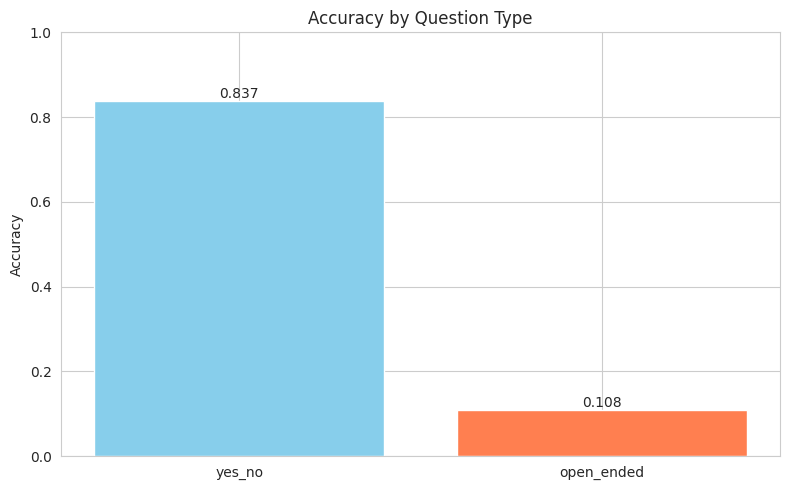

In [182]:
# Per-question-type analysis
per_type_metrics = test_metrics.compute_per_question_type()

if per_type_metrics:
    print("\nPerformance by Question Type:")
    print("=" * 50)

    for qtype, stats in per_type_metrics.items():
        print(f"\n{qtype.upper()}:")
        print(f"  Count: {stats['count']:,}")
        print(f"  Accuracy: {stats['accuracy']:.4f}")

    # Visualize
    fig, ax = plt.subplots(figsize=(8, 5))
    types = list(per_type_metrics.keys())
    accs = [per_type_metrics[t]['accuracy'] for t in types]

    bars = ax.bar(types, accs, color=['skyblue', 'coral'])
    ax.set_ylabel('Accuracy')
    ax.set_title('Accuracy by Question Type')
    ax.set_ylim(0, 1)

    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

## 10. Error Analysis

In [183]:
# Get confusion statistics
confusion_stats = test_metrics.get_confusion_stats(top_k=10)

print("\nTop 10 Most Confused Answer Pairs:")
print("=" * 70)
print(f"{'True Answer':<25} {'Predicted Answer':<25} {'Count':>10}")
print("-" * 70)

# Get answer vocabulary
with open(project_root / config['data']['answers_file'], 'r', encoding='utf-8') as f:
    answers = [line.strip() for line in f.readlines()]

for (true_idx, pred_idx), count in confusion_stats['top_confusions']:
    true_ans = answers[true_idx] if true_idx < len(answers) else f"idx_{true_idx}"
    pred_ans = answers[pred_idx] if pred_idx < len(answers) else f"idx_{pred_idx}"
    print(f"{true_ans:<25} {pred_ans:<25} {count:>10}")

print(f"\nTotal errors: {confusion_stats['total_errors']:,}")


Top 10 Most Confused Answer Pairs:
True Answer               Predicted Answer               Count
----------------------------------------------------------------------
yes                       no                               282
no                        yes                              267
endocrine                 cardiovascular                    96
hepatobiliary             cardiovascular                    87
gastrointestinal          cardiovascular                    84
hematologic               cardiovascular                    72
female reproductive       cardiovascular                    62
vasculature               cardiovascular                    54
liver                     cardiovascular                    52
oral                      cardiovascular                    42

Total errors: 3,559


## 11. Sample Predictions

In [184]:
# Show some example predictions
model.eval()
sample_batch = next(iter(test_loader))

with torch.no_grad():
    questions = sample_batch['question'].to(device)
    outputs = model(questions)
    predictions, probabilities = model.predict(questions)

# Show first 10 examples
print("Sample Predictions:")
print("=" * 100)

for i in range(min(10, len(sample_batch['question_text']))):
    question = sample_batch['question_text'][i]
    true_answer = sample_batch['answer_text'][i]
    pred_idx = predictions[i].item()
    pred_answer = answers[pred_idx] if pred_idx < len(answers) else f"idx_{pred_idx}"
    confidence = probabilities[i].max().item()

    is_correct = " " if pred_answer.lower() == true_answer.lower() else " "

    print(f"\n{is_correct} Example {i+1}:")
    print(f"  Question: {question}")
    print(f"  True Answer: {true_answer}")
    print(f"  Predicted: {pred_answer} (confidence: {confidence:.3f})")

Sample Predictions:

  Example 1:
  Question: Is squamous cell carcinoma composed of nests of malignant cells that partially recapitulate the stratified organization of squamous epithelium?
  True Answer: yes
  Predicted: yes (confidence: 0.962)

  Example 2:
  Question: What is composed of nests of malignant cells that partially recapitulate the stratified organization of squamous epithelium?
  True Answer: squamous cell carcinoma
  Predicted: this (confidence: 0.038)

  Example 3:
  Question: Is low magnification composed of nests of malignant cells that partially recapitulate the stratified organization of squamous epithelium?
  True Answer: no
  Predicted: yes (confidence: 0.513)

  Example 4:
  Question: Is section from margin of amoebic ulcer mild epithelial hyperplasia in terminal ducts?
  True Answer: no
  Predicted: no (confidence: 0.549)

  Example 5:
  Question: Is there mild epithelial hyperplasia in terminal ducts?
  True Answer: yes
  Predicted: yes (confidence: 0.708)

 

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


## 12. Save Results Summary

In [185]:
# Create results summary
results_summary = {
    'model_type': 'LSTM',
    'vocab_size': vocab_size,
    'num_classes': num_classes,
    'total_parameters': total_params,
    'test_accuracy': metrics['accuracy'],
    'test_f1_macro': metrics['f1_macro'],
    'test_f1_weighted': metrics['f1_weighted'],
    'test_precision': metrics['precision_macro'],
    'test_recall': metrics['recall_macro'],
    'best_val_accuracy': trainer.best_val_acc,
}

# Save to file
results_dir = project_root / 'results'
results_dir.mkdir(exist_ok=True)

import json
with open(results_dir / 'text_baseline_results.json', 'w') as f:
    json.dump(results_summary, f, indent=2)

print("  Results saved to results/text_baseline_results.json")
print("\nSummary:")
for key, value in results_summary.items():
    if isinstance(value, float):
        print(f"  {key}: {value:.4f}")
    else:
        print(f"  {key}: {value}")

  Results saved to results/text_baseline_results.json

Summary:
  model_type: LSTM
  vocab_size: 3965
  num_classes: 4592
  total_parameters: 2609520
  test_accuracy: 0.4736
  test_f1_macro: 0.0079
  test_f1_weighted: 0.4434
  test_precision: 0.0079
  test_recall: 0.0122
  best_val_accuracy: 0.4474


## 13. Conclusion and Next Steps

### What we've achieved:
-   Built vocabulary from medical questions
-   Trained LSTM model to predict answers from text only
-   Evaluated performance on test set
-   Analyzed results by question type

### Expected Performance:
- **Text-only baseline**: 15-30% accuracy
- This is significantly better than random (0.02% for 4,593 classes)
- But limited without visual information!

### Next Steps:
1. **Add Vision**: Implement CNN image encoder
2. **Multimodal Fusion**: Combine text + image features
3. **Attention Mechanisms**: Let model focus on relevant image regions
4. **Pre-trained VLMs**: Use BLIP, CLIP, or similar models
5. **Fine-tuning**: Optimize on PathVQA dataset

### Model Checkpoint:
Your trained model is saved at:
```
checkpoints/text_baseline_lstm_notebook/best_model.pth
```

You can load it later for inference or further training!